# Examples EO datasets of project derived data

This is a notebook showcasing workflow examples for downloading earth observation rater data created within the project. c

### Data download examples in this notebook:


1.  Climate Indicators

3.  Drone imagery

In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from eolearn.core import FeatureType, EOPatch
from eolearn.io import SentinelHubEvalscriptTask
from sentinelhub import CRS, Band, BBox, DataCollection, Unit, SHConfig, SentinelHubBYOC
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# General parameters and utilities

In [75]:
config = SHConfig()
byoc = SentinelHubBYOC(config=config)
# region of interest
europe_bbox = BBox(bbox=[-12.128906,34.885931,40.781250,71.965388], crs=CRS.WGS84)

#### Utility functions

In [40]:
indicator_to_human_name_map = {
    "evapo": "Evapotranspiration",
    "mrsos": "Soil Moisture",
    "nsat": "Near Surface Air Temperature",
    "nsrh": "Near Surface Relative Humidity",
    "tavg": "Average Temperature",
    "tmax": "Maximum Temperature",
    "tmin": "Minimum Temperature",
}

def get_layer_name(band: str) -> str:
    indicator = band.split("_")[0]
    human_name = indicator_to_human_name_map[indicator]
    if  band.split("_")[1] in ("ref", "historical"): 
        return f"{human_name} (Historical)"   
    
    ssp = None 
    if band.split("_")[2] == "85": 
       ssp = "SSP5-8.5" 
    elif band.split("_")[2] == "45": 
        ssp = "SSP2-4.5" 
    else: 
        raise ValueError(f"Could not parse SSP value {band.split('_')[2]}")
    
    year = band.split("_")[4]
    name = f"{human_name} {ssp} projection for {year}"
    return name


def create_download_evalscript(band: str) -> str:
    evalscript = f"""
//VERSION=3
function setup() {{
  return {{
  input: ["{band}", "dataMask"],
  output: [{{ id: "{band}", bands: 1, sampleType: SampleType.FLOAT32 }}, {{ id: "dataMask", bands: 1, sampleType: SampleType.AUTO }} ]
  }};
}}

function evaluatePixel(sample) {{
  return {{ "{band}": [sample.{band}], 
            "dataMask": [sample.dataMask]}};
}}
"""
    return evalscript


# Indicators 

## Soil Moisture 

In [69]:
collection_id = "97e95ed8-51ce-4f55-a41b-73d957743c52"
col = byoc.get_collection(collection_id)
band_names = [band for band in col["additionalData"]["bands"]]

collection = DataCollection.define_byoc(
    collection_id=collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
)



In [70]:
ramp = [
  [11, 0xff0000],
  [15, 0xff5f00],
  [19, 0xff8300],
  [23, 0xffa600],
  [28, 0xffb200],
  [32, 0xffd500],
  [36, 0xfff800],
  [41, 0x00ffc5],
  [45, 0x00f2ff],
  [49, 0x00cfff],
  [53, 0x00b7ff],
  [58, 0x0088ff],
  [62, 0x0065ff],
  [66, 0x001eff],
  [71, 0x0f00dd]
]
from matplotlib.colors import LinearSegmentedColormap

colormap = LinearSegmentedColormap.from_list("dsd", [f'#{hex(color)[2:].zfill(6)}' for _, color in ramp])

In [71]:
eopatch = EOPatch(bbox=europe_bbox)

In [72]:
for band_name in band_names: 
    print(f"Downloading data for {band_name}...")
    indicator_download_task = SentinelHubEvalscriptTask(
        features=[(FeatureType.DATA, band_name), (FeatureType.MASK, "dataMask")],
        evalscript=create_download_evalscript(band_name),
        data_collection=collection,
        resolution=10000,
        max_threads=3
    )
    eopatch = indicator_download_task.execute(eopatch=eopatch, bbox=europe_bbox, time_interval=["2024-01-01", "2024-01-02"])

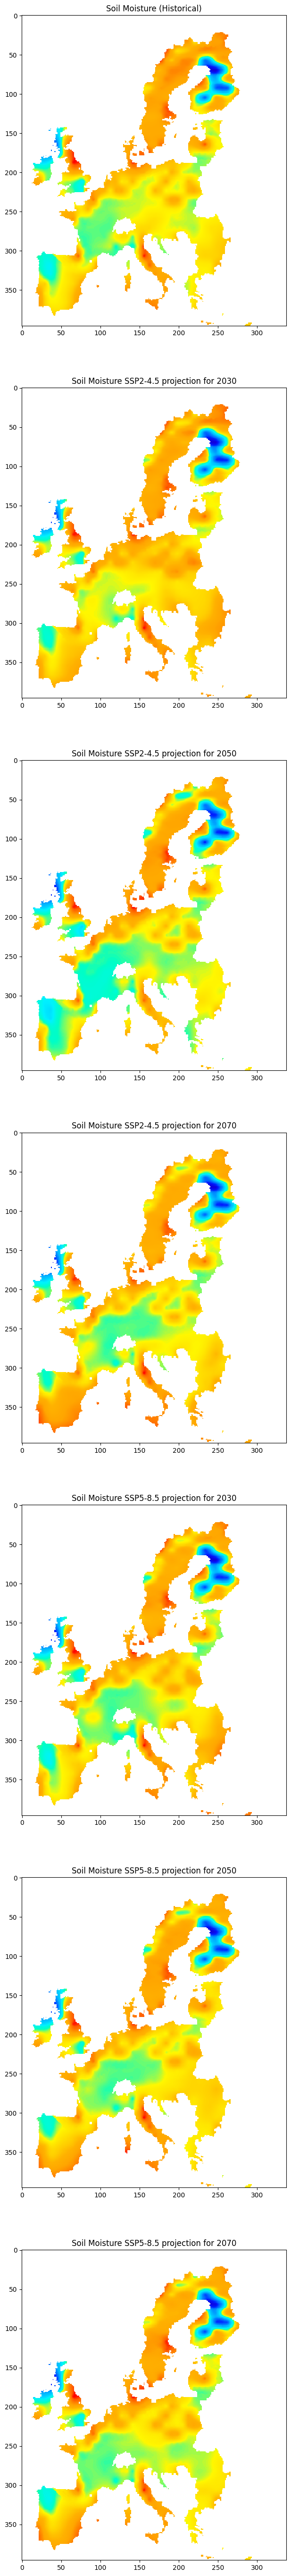

In [73]:
 
fig, axs = plt.subplots(nrows=len(band_names),figsize=(10, 10*len(band_names)))


for  i, band_name in enumerate(band_names): 
    indicator_data = eopatch.data[band_name][0].squeeze()
    indicator_data[eopatch.mask["dataMask"].squeeze() == 0] = np.nan 

    axs[i].imshow(indicator_data, cmap=colormap)
    axs[i].set_title(get_layer_name(band_name))

## Near Surface Relative Humidity

In [64]:
collection_id = "f04e2207-04ce-47f2-af2e-9089cb0ec1fb"
col = byoc.get_collection(collection_id)
band_names = [band for band in col["additionalData"]["bands"]]

collection = DataCollection.define_byoc(
    collection_id=collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
)



In [65]:
ramp = [
  [61, 0xff0000],
  [63, 0xff5f00],
  [65, 0xff8300],
  [67, 0xffa600],
  [69, 0xffb200],
  [72, 0xffd500],
  [74, 0xfff800],
  [76, 0x00ffc5],
  [78, 0x00f2ff],
  [80, 0x00cfff],
  [83, 0x00b7ff],
  [85, 0x0088ff],
  [87, 0x0065ff],
  [89, 0x001eff],
  [92, 0x0f00dd]
]
from matplotlib.colors import LinearSegmentedColormap

colormap = LinearSegmentedColormap.from_list("dsd", [f'#{hex(color)[2:].zfill(6)}' for _, color in ramp])

In [66]:
eopatch = EOPatch(bbox=europe_bbox)

In [67]:
for band_name in band_names: 
    print(f"Downloading data for {band_name}...")
    indicator_download_task = SentinelHubEvalscriptTask(
        features=[(FeatureType.DATA, band_name), (FeatureType.MASK, "dataMask")],
        evalscript=create_download_evalscript(band_name),
        data_collection=collection,
        resolution=10000,
        max_threads=3
    )
    eopatch = indicator_download_task.execute(eopatch=eopatch, bbox=europe_bbox, time_interval=["2024-01-01", "2024-01-02"])

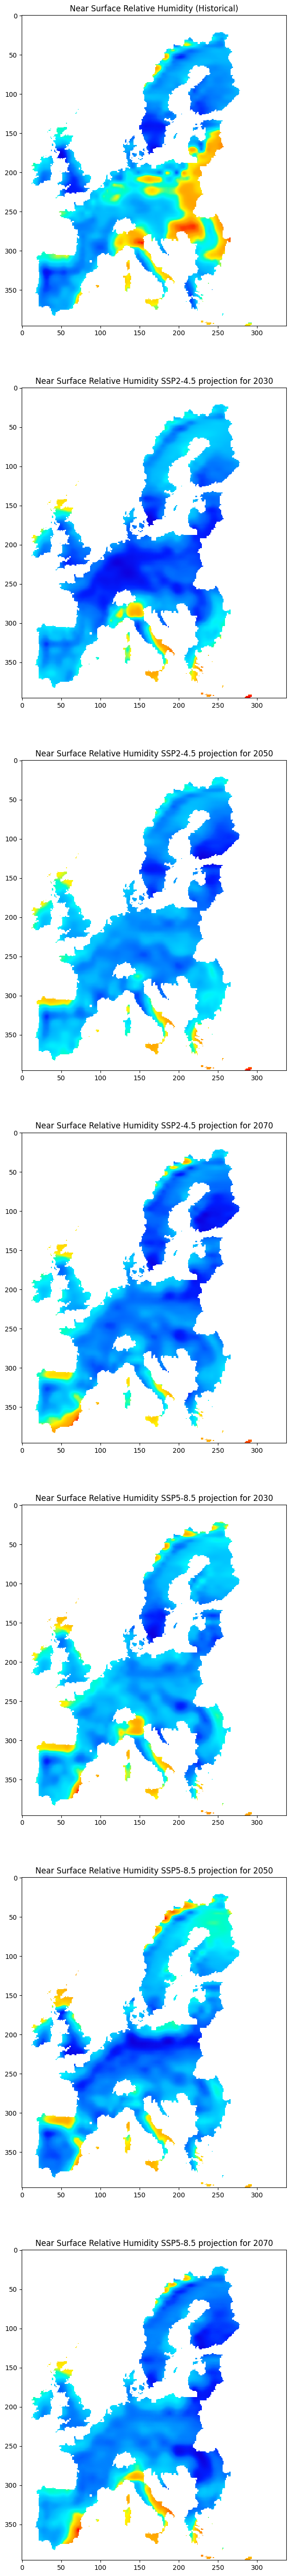

In [68]:
 
fig, axs = plt.subplots(nrows=len(band_names),figsize=(10, 10*len(band_names)))


for  i, band_name in enumerate(band_names): 
    indicator_data = eopatch.data[band_name][0].squeeze()
    indicator_data[eopatch.mask["dataMask"].squeeze() == 0] = np.nan 

    axs[i].imshow(indicator_data, cmap=colormap)
    axs[i].set_title(get_layer_name(band_name))

## Near Surface Air Temperature

In [59]:
collection_id = "9ca6af76-4e65-4497-97d2-474c5e67d7b9"
col = byoc.get_collection(collection_id)
band_names = [band for band in col["additionalData"]["bands"]]

collection = DataCollection.define_byoc(
    collection_id=collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
)



In [60]:
ramp = [
  [-20,   0x0008ff],
  [-17.7, 0x0043ff],
  [-15.4, 0x004eff],
  [-13.1, 0x0095ff],
  [-10.8, 0x00adff],
  [-8.5,  0x00f3ff],
  [-6.2,  0x00ffff],
  [-4,    0xccff00],
  [-1.7,  0xffeb00],
  [0.5,   0xffbc00],
  [2.8,   0xffa500],
  [5.1,   0xff8100],
  [7.4,   0xff6a00],
  [9.7,   0xff0c00],
  [12,    0xc80000]
]
from matplotlib.colors import LinearSegmentedColormap

colormap = LinearSegmentedColormap.from_list("dsd", [f'#{hex(color)[2:].zfill(6)}' for _, color in ramp])

In [61]:
eopatch = EOPatch(bbox=europe_bbox)

In [62]:
for band_name in band_names: 
    print(f"Downloading data for {band_name}...")
    indicator_download_task = SentinelHubEvalscriptTask(
        features=[(FeatureType.DATA, band_name), (FeatureType.MASK, "dataMask")],
        evalscript=create_download_evalscript(band_name),
        data_collection=collection,
        resolution=10000,
        max_threads=3
    )
    eopatch = indicator_download_task.execute(eopatch=eopatch, bbox=europe_bbox, time_interval=["2024-01-01", "2024-01-02"])

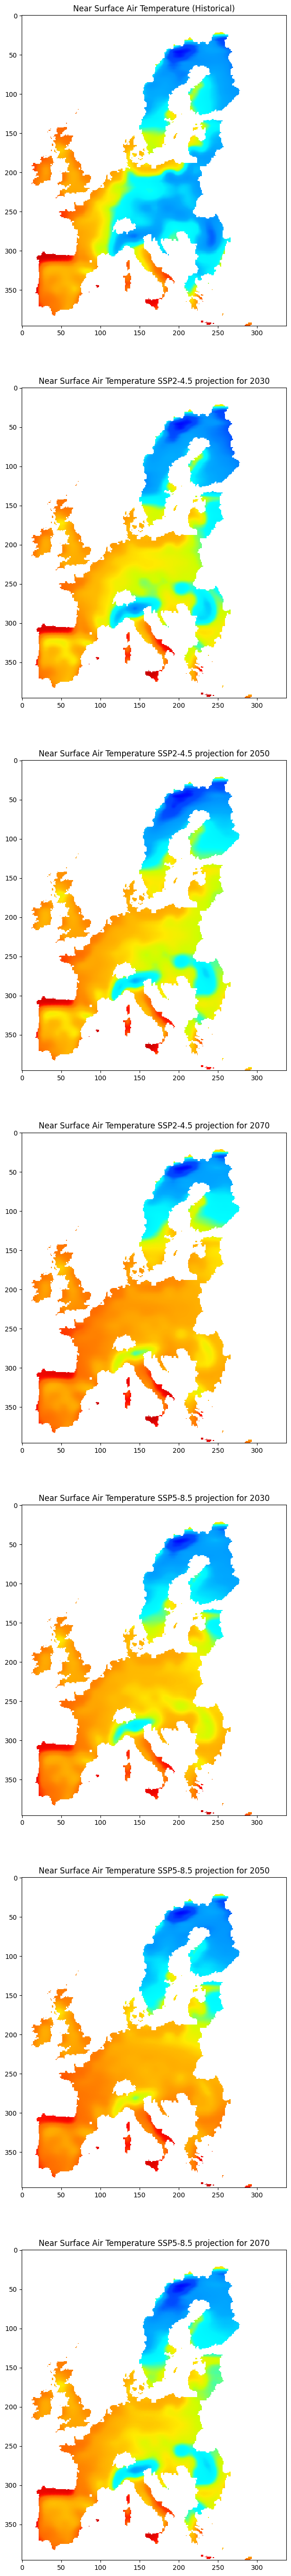

In [63]:
 
fig, axs = plt.subplots(nrows=len(band_names),figsize=(10, 10*len(band_names)))


for  i, band_name in enumerate(band_names): 
    indicator_data = eopatch.data[band_name][0].squeeze()
    indicator_data[eopatch.mask["dataMask"].squeeze() == 0] = np.nan 

    axs[i].imshow(indicator_data, cmap=colormap)
    axs[i].set_title(get_layer_name(band_name))

## Minimum Temperature

In [54]:
collection_id = "85909905-6d7a-4181-bc21-21188861df88"
col = byoc.get_collection(collection_id)
band_names = [band for band in col["additionalData"]["bands"]]

collection = DataCollection.define_byoc(
    collection_id=collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
)



In [55]:
ramp = [
  [-7,    0x0008ff],
  [-5.29, 0x0043ff],
  [-3.57, 0x004eff],
  [-1.86, 0x0095ff],
  [-0.14, 0x00adff],
  [1.57,  0x00f3ff],
  [3.29,  0x00ffff],
  [5.00,  0xccff00],
  [6.71,  0xffeb00],
  [8.43,  0xffbc00],
  [10.14, 0xffa500],
  [11.86, 0xff8100],
  [13.57, 0xff6a00],
  [15.29, 0xff0c00],
  [17,    0xc80000]
]
from matplotlib.colors import LinearSegmentedColormap

colormap = LinearSegmentedColormap.from_list("dsd", [f'#{hex(color)[2:].zfill(6)}' for _, color in ramp])

In [56]:
eopatch = EOPatch(bbox=europe_bbox)

In [57]:
for band_name in band_names: 
    print(f"Downloading data for {band_name}...")
    indicator_download_task = SentinelHubEvalscriptTask(
        features=[(FeatureType.DATA, band_name), (FeatureType.MASK, "dataMask")],
        evalscript=create_download_evalscript(band_name),
        data_collection=collection,
        resolution=10000,
        max_threads=3
    )
    eopatch = indicator_download_task.execute(eopatch=eopatch, bbox=europe_bbox, time_interval=["2024-01-01", "2024-01-02"])

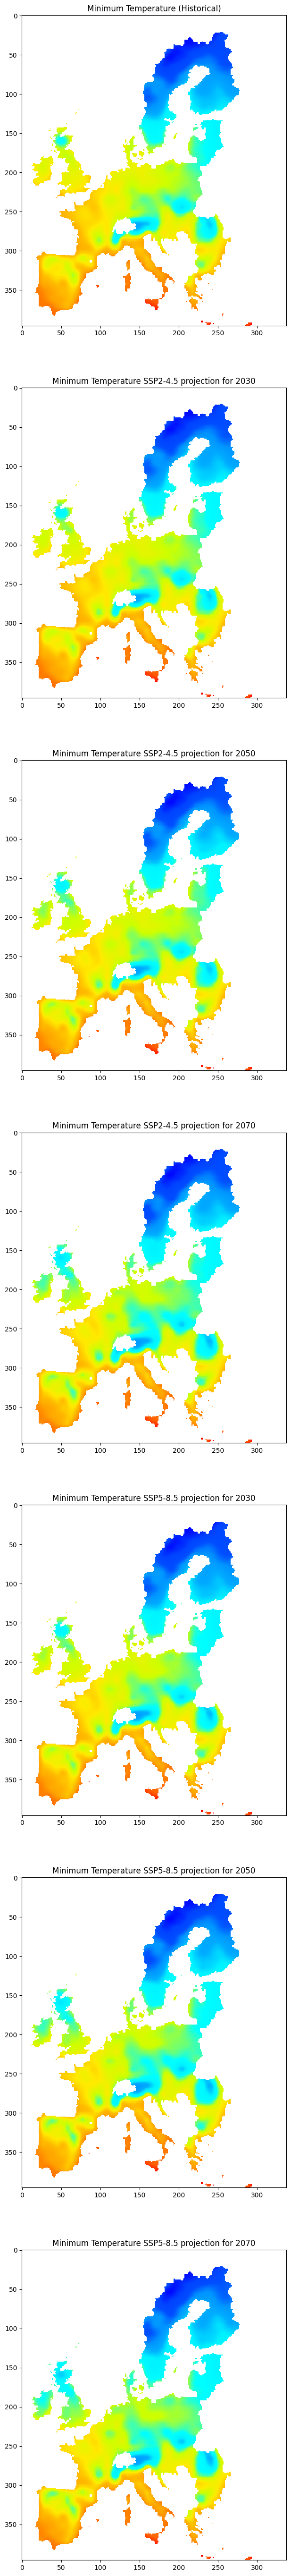

In [58]:
 
fig, axs = plt.subplots(nrows=len(band_names),figsize=(10, 10*len(band_names)))


for  i, band_name in enumerate(band_names): 
    indicator_data = eopatch.data[band_name][0].squeeze()
    indicator_data[eopatch.mask["dataMask"].squeeze() == 0] = np.nan 

    axs[i].imshow(indicator_data, cmap=colormap)
    axs[i].set_title(get_layer_name(band_name))

## Maximum Temperature 

In [49]:
collection_id = "6777e5d3-3309-4771-a38a-79addcf31d36"
col = byoc.get_collection(collection_id)
band_names = [band for band in col["additionalData"]["bands"]]

collection = DataCollection.define_byoc(
    collection_id=collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
)



In [50]:
ramp = [
  [0.5,   0x0008ff],
  [2.18,  0x0043ff],
  [3.86,  0x004eff],
  [5.54,  0x0095ff],
  [7.21,  0x00adff],
  [8.89,  0x00f3ff],
  [10.57, 0x00ffff],
  [12.25, 0xccff00],
  [13.93, 0xffeb00],
  [15.61, 0xffbc00],
  [17.29, 0xffa500],
  [18.96, 0xff8100],
  [20.64, 0xff6a00],
  [22.32, 0xff0c00],
  [24,    0xc80000]
]
from matplotlib.colors import LinearSegmentedColormap

colormap = LinearSegmentedColormap.from_list("dsd", [f'#{hex(color)[2:].zfill(6)}' for _, color in ramp])

In [51]:
eopatch = EOPatch(bbox=europe_bbox)

In [52]:
for band_name in band_names: 
    print(f"Downloading data for {band_name}...")
    indicator_download_task = SentinelHubEvalscriptTask(
        features=[(FeatureType.DATA, band_name), (FeatureType.MASK, "dataMask")],
        evalscript=create_download_evalscript(band_name),
        data_collection=collection,
        resolution=10000,
        max_threads=3
    )
    eopatch = indicator_download_task.execute(eopatch=eopatch, bbox=europe_bbox, time_interval=["2024-01-01", "2024-01-02"])

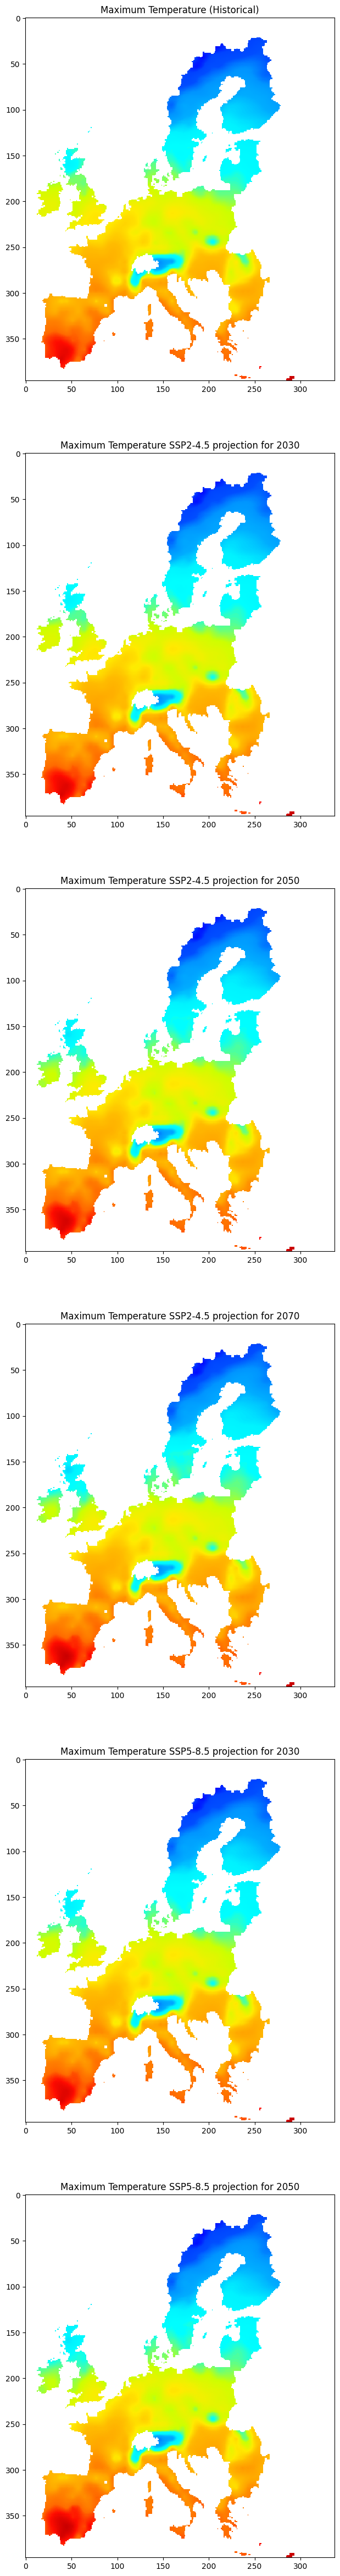

In [53]:
 
fig, axs = plt.subplots(nrows=len(band_names),figsize=(10, 10*len(band_names)))


for  i, band_name in enumerate(band_names): 
    indicator_data = eopatch.data[band_name][0].squeeze()
    indicator_data[eopatch.mask["dataMask"].squeeze() == 0] = np.nan 

    axs[i].imshow(indicator_data, cmap=colormap)
    axs[i].set_title(get_layer_name(band_name))

## Evapotranspiration

In [43]:
collection_id = "13d40522-205b-42e8-8b34-4ddb27fd3452"
col = byoc.get_collection(collection_id)
band_names = [band for band in col["additionalData"]["bands"]]

collection = DataCollection.define_byoc(
    collection_id=collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
)



In [44]:
ramp = [
  [0,    0xff0000],
  [135,  0xff5f00],
  [271,  0xff8300],
  [407,  0xffa600],
  [542,  0xffb200],
  [678,  0xffd500],
  [814,  0xfff800],
  [950,  0xcbff00],
  [1085, 0xb3ff00],
  [1221, 0x9cff00],
  [1357, 0x61ff00],
  [1492, 0x49ff00],
  [1628, 0x3eff00],
  [1764, 0x26ff00],
  [1900, 0x0de100]
]
from matplotlib.colors import LinearSegmentedColormap

colormap = LinearSegmentedColormap.from_list("dsd", [f'#{hex(color)[2:].zfill(6)}' for _, color in ramp])

In [45]:
eopatch = EOPatch(bbox=europe_bbox)

In [46]:
for band_name in band_names: 
    print(f"Downloading data for {band_name}...")
    indicator_download_task = SentinelHubEvalscriptTask(
        features=[(FeatureType.DATA, band_name), (FeatureType.MASK, "dataMask")],
        evalscript=create_download_evalscript(band_name),
        data_collection=collection,
        resolution=10000,
        max_threads=3
    )
    eopatch = indicator_download_task.execute(eopatch=eopatch, bbox=europe_bbox, time_interval=["2024-01-01", "2024-01-02"])

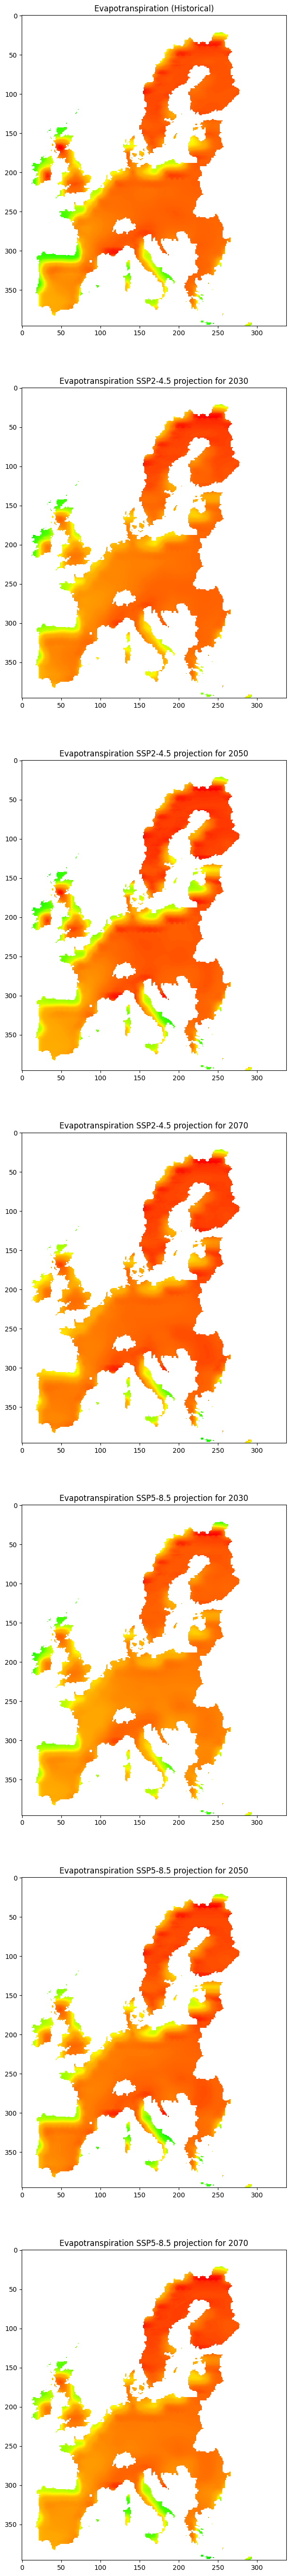

In [48]:
 
fig, axs = plt.subplots(nrows=len(band_names),figsize=(10, 10*len(band_names)))


for  i, band_name in enumerate(band_names): 
    indicator_data = eopatch.data[band_name][0].squeeze()
    indicator_data[eopatch.mask["dataMask"].squeeze() == 0] = np.nan 

    axs[i].imshow(indicator_data, cmap=colormap)
    axs[i].set_title(get_layer_name(band_name))

## Average Temperature

In [26]:
collection_id = "4004f3ee-e5d9-4c2b-a937-de32781b1b91"
col = byoc.get_collection(collection_id)
band_names = [band for band in col["additionalData"]["bands"]]

collection = DataCollection.define_byoc(
    collection_id=collection_id,
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
)



In [33]:
ramp = [
    [-3, 0x0008ff],
    [-1.43, 0x0043ff],
    [0.14, 0x004eff],
    [1.71, 0x0095ff],
    [3.29, 0x00adff],
    [4.86, 0x00f3ff],
    [6.43, 0x00ffff],
    [8.00, 0xccff00],
    [9.57, 0xffeb00],
    [11.14, 0xffbc00],
    [12.71, 0xffa500],
    [14.29, 0xff8100],
    [15.86, 0xff6a00],
    [17.43, 0xff0c00],
    [19, 0xc80000]
]
from matplotlib.colors import LinearSegmentedColormap

colormap = LinearSegmentedColormap.from_list("dsd", [f'#{hex(color)[2:].zfill(6)}' for _, color in ramp])

In [34]:
eopatch = EOPatch(bbox=europe_bbox)

In [35]:
for band_name in band_names: 
    print(f"Downloading data for {band_name}...")
    indicator_download_task = SentinelHubEvalscriptTask(
        features=[(FeatureType.DATA, band_name), (FeatureType.MASK, "dataMask")],
        evalscript=create_download_evalscript(band_name),
        data_collection=collection,
        resolution=10000,
        max_threads=3
    )
    eopatch = indicator_download_task.execute(eopatch=eopatch, bbox=europe_bbox, time_interval=["2024-01-01", "2024-01-02"])

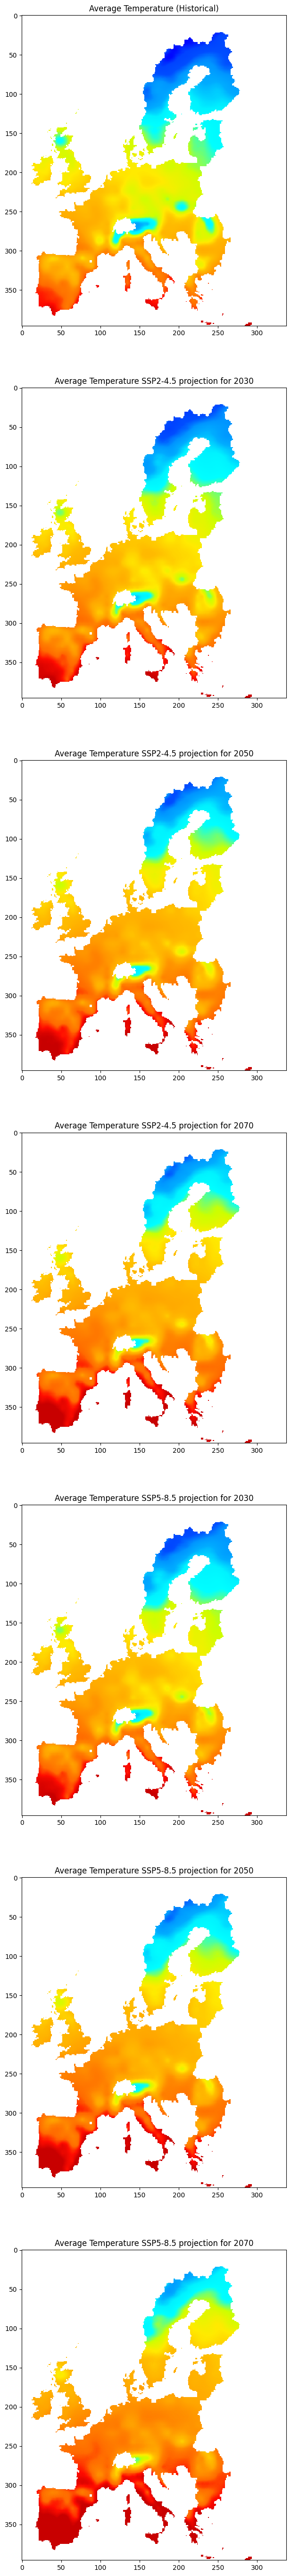

In [41]:
 
fig, axs = plt.subplots(nrows=len(band_names),figsize=(10, 10*len(band_names)))


for  i, band_name in enumerate(band_names): 
    indicator_data = eopatch.data[band_name][0].squeeze()
    indicator_data[eopatch.mask["dataMask"].squeeze() == 0] = np.nan 

    axs[i].imshow(indicator_data, cmap=colormap, vmin=-3, vmax=19)
    axs[i].set_title(get_layer_name(band_name))